# Dynamic Tropopause Map

 http://www.met.nps.edu/~hmarcham/2012.html#DT
 The dynamic tropopause map contains
 DT (1.5-PVU surface)
    - potential temperature (shaded, K)
    - wind barbs (knots)
    - 925-850hPa layer-averaged cyclonic relative vorticity (black contours, every 0.5 x 10^-4 s^-1)



 http://apps.ecmwf.int/codes/grib/param-db
 #### Parameters from ECMWF
    - name = 'Potential temperature',      shortName = 'pt',     [K]
    - name = 'U component of wind',        shortName = 'u',      [m s^-1]
    - name = 'V component of wind',        shortName = 'v',      [m s^-1]
    - name = 'Vorticity (relative)',       shortName = 'vo',     [s^-1]



https://software.ecmwf.int/wiki/display/CKB/How+to+plot+GRIB+files+with+Python+and+matplotlib

In [81]:
import pygrib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
from scipy import ndimage
from datetime import date
import calendar
%matplotlib inline     

In [82]:
### set the file name of your input GRIB file
#grib = 'DT_var.grib'
year = '2016'
mon  = '12'
day = '10' 
time = '00'

gribPT = '../test_data/pv2000/param_pt_%s%s%s_%s00.grib' % (year, mon, day, time)    #20161210_0000.grib'
gribUV = '../test_data/pv2000/param_uv_%s%s%s_%s00.grib' % (year, mon, day, time)    #20161210_0000.grib'
gribVO = '../test_data/pl/param_vo_%s%s%s_%s00.grib'     % (year, mon, day, time)    #20161210_0000.grib'


### open GRIB file
grbsPT = pygrib.open(gribPT)         # potential temperature
grbsUV = pygrib.open(gribUV)         # U, V component of wind
grbsVO = pygrib.open(gribVO)         # Vorticity (relative)



grib = '../DT_var.grib'
grbs = pygrib.open(grib)


In [83]:
grbPT = grbsPT.select()[0]           # finds the first grib message, if grbs.select(name='Maximum temperature') 
                                     # then first with matching name
grbUV = grbsUV.select()[0]
grbVO = grbsVO.select()[0]



grb = grbs.select()[0]

In [84]:
print('pot. temp.:', grbPT.dataDate,grbPT.dataTime)                 # gives the date and forecast time
print('U, V component of wind:', grbUV.dataDate,grbUV.dataTime)
print('Vorticity (relative):', grbVO.dataDate,grbVO.dataTime)

pot. temp.: 20161210 0
U, V component of wind: 20161210 0
Vorticity (relative): 20161210 0


In [85]:
### get the values into python
# find the first grib message with a matching name: 

## Potential temperature
PT = grbsPT.select()[0]
PT = grbsPT.select(shortName = 'pt',typeOfLevel = 'potentialVorticity',level = 2000)[0]
PT = PT.values

#PT.shape
#print(PT.max(),PT.min())

PT = grbs.select()[0]
PT = grbs.select(shortName = 'pt',typeOfLevel = 'potentialVorticity',level = 2000)[0]
PT = PT.values

In [86]:
## Wind 
# U component of wind
wind_u = grbsUV.select()[0]
wind_u = grbsUV.select(shortName = 'u',typeOfLevel = 'potentialVorticity',level = 2000)[0]
wind_u = wind_u.values
#print(wind_u.max(),wind_u.min())

# V component of wind
wind_v = grbsUV.select()[0]
wind_v = grbsUV.select(shortName = 'v',typeOfLevel = 'potentialVorticity',level = 2000)[0]
wind_v = wind_v.values
#print(wind_v.max(),wind_v.min())

wind_u = grbs.select()[0]
wind_u = grbs.select(shortName = 'u',typeOfLevel = 'potentialVorticity',level = 2000)[0]
wind_u = wind_u.values

wind_v = grbs.select()[0]
wind_v = grbs.select(shortName = 'v',typeOfLevel = 'potentialVorticity',level = 2000)[0]
wind_v = wind_v.values

In [87]:
## Vorticity (relative)
# 925 hPa
RV925 = grbsVO.select()[0]
RV925 = grbsVO.select(shortName = 'vo',typeOfLevel = 'isobaricInhPa', level = 925)[0]
RV925 = RV925.values
#print(RV925.max(),RV925.min())

# 900 hPa
RV900 = grbsVO.select()[0]
RV900 = grbsVO.select(shortName = 'vo',typeOfLevel = 'isobaricInhPa', level = 900)[0]
RV900 = RV900.values
#print(RV900.max(),RV900.min())

# 850 hPa
RV850 = grbsVO.select()[0]
RV850 = grbsVO.select(shortName = 'vo',typeOfLevel = 'isobaricInhPa', level = 850)[0]
RV850 = RV850.values
#print(RV850.max(),RV850.min())

RV925 = grbs.select()[0]
RV925 = grbs.select(shortName = 'vo',typeOfLevel = 'isobaricInhPa', level = 925)[0]
RV925 = RV925.values

RV900 = grbs.select()[0]
RV900 = grbs.select(shortName = 'vo',typeOfLevel = 'isobaricInhPa', level = 900)[0]
RV900 = RV900.values

RV850 = grbs.select()[0]
RV850 = grbs.select(shortName = 'vo',typeOfLevel = 'isobaricInhPa', level = 850)[0]
RV850 = RV850.values

In [88]:
### calculating 925-850 hPa layer-averaged cyclonic relative vorticity (every 0.5 x10^-4 s-1)
# all three layers divided by number of layers
#rel_vort = np.sqrt( RV900**2 + 2*RV850**2 + RV925**2 )   # Aina's solution

rel_vort = (RV925+RV900+RV850)/3                         # arithmetric mean
#rel_vort = (RV925+RV900+2*RV850)/(4)                      # weighted arithmetric mean
#rel_vort = (RV925*RV900*RV850)**(1/3.)                   # geometric mean 
#rel_vort = (RV925**1+RV900**1+RV850**2)**4               # weighted geometric mean
#rel_vort = (3)*(1/RV925 + 1/RV900 + 1/RV850)            # h harmonic mean
#rel_vort = (4)/(1/RV925+1/RV900+2/RV850)                  # weighted harmonic mean

rel_vort = ndimage.filters.gaussian_filter(rel_vort, sigma = 2)

In [89]:
### Latitudes, Longitudes and shiftgrid
# get the latitudes and longitudes of the grid
latPT,lonPT = grbPT.latlons()           # Set the names of the latitude and longitude variables in your input GRIB 
                                        # file 
latUV,lonUV = grbUV.latlons()
latVO,lonVO = grbVO.latlons()

#print(latUV.max(),latUV.min(), lonUV.max(), lonUV.min())
#print(latUV.shape, lonUV.shape)

lat,lon = grb.latlons()
print(lon[0,:])

In [90]:
lonsPT = lonPT[0,:]                     #use only one row
lonsUV = lonUV[0,:]
lonsVO = lonVO[0,:]

PT,lonsPT = shiftgrid(180.,PT,lonsPT,start=False)          #shift all values from >180 deg
wind_u,lonsUV = shiftgrid(180.,wind_u,lonsUV,start=False)
rel_vort,lonsVO = shiftgrid(180.,rel_vort,lonsVO,start=False)    #shift all values from >180 deg


latsPT = latPT[:,0]                   # use only first column
latsUV = latUV[:,0]
latsVO = latVO[:,0]


#print(lonsPT.shape,latsPT.shape,PT.shape)
#print(lonsUV.shape,latsUV.shape,wind_u.shape)
#print(lonsUV.shape,latsUV.shape,wind_v.shape)
#print(lonsVO.shape,latsVO.shape,rel_vort.shape)

lons = lon[0,:]
PT,lons = shiftgrid(180.,PT,lons,start=False)
lats = lat[:,0]




In [91]:
### Wind
# use only every 20, 35 value from the wind
UVlats = np.zeros((64,),dtype =float)
UVlons = np.zeros((74,),dtype =float)
u_wind = np.zeros((64,2560), dtype = float)
v_wind = np.zeros((64,2560), dtype = float)
u_wind2 = np.zeros((64,74),dtype = float)
v_wind2 = np.zeros((64,74),dtype = float)

    
#numrows = len(wind_u)    
#numcols = len(wind_u[0]) 
#print(numrows,numcols)

for i in range(0,64):
    UVlats[i] = latsUV[i*20]
    u_wind[i,:] = wind_u[i*20,:]
    v_wind[i,:] = wind_v[i*20,:]

for k in range(0,74):
    UVlons[k] = lonsUV[k*35]   
    u_wind2[:,k] = u_wind[:,k*35]
    v_wind2[:,k] = v_wind[:,k*35]


#print(UVlats.shape,UVlons.shape,u_wind2.shape,v_wind2.shape)


### Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html



In [92]:
# Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html
m = Basemap(projection='merc', \
            llcrnrlon=-60., urcrnrlon=50., \
            llcrnrlat=30.,urcrnrlat=75., \
            resolution='l')

In [93]:
#m = Basemap(projection='merc', \
#            llcrnrlon=-160., urcrnrlon=-60., \
#            llcrnrlat=20.,urcrnrlat=60., \
#            resolution='c')

#m = Basemap(projection='cyl', \
#            llcrnrlon=-180., urcrnrlon=180., \
#            llcrnrlat=latsPT.min(),urcrnrlat=latsPT.max(), \
#            resolution='c')


lonsPT,latsPT = np.meshgrid(lonsPT,latsPT)            #creates a grid with values of the size of PT
lonsVO,latsVO = np.meshgrid(lonsVO,latsVO)
UVlons,UVlats = np.meshgrid(UVlons,UVlats)


plonsPT, platsPT = m(lonsPT,latsPT)
plonsVO, platsVO = m(lonsVO,latsVO)
plonsUV, platsUV = m(UVlons,UVlats)

#print(plonsPT.shape,platsPT.shape,PT.shape)
#print(plonsVO.shape,platsVO.shape,rel_vort.shape)
#print(plonsUV.shape,platsUV.shape,u_wind2.shape)


lons,lats = np.meshgrid(lons,lats)
plons, plats = m(lons,lats)


In [94]:
### define colors for colorbar
champ = 255
no1 = np.array([231,231,231])/champ
no2 = np.array([201,201,201])/champ
no3 = np.array([171,171,171])/champ
no4 = np.array([140,140,140])/champ
no5 = np.array([110,110,110])/champ
no6 = np.array([102,81,224])/champ
no7 = np.array([105,115,224])/champ
no8 = np.array([103,134,255])/champ
no9 = np.array([132,159,254])/champ
no10= np.array([178,202,255])/champ
no11= np.array([217,241,255])/champ
no12= np.array([255,209,177])/champ
no13= np.array([255,165,133])/champ
no14= np.array([255,118,86])/champ
no15= np.array([255,62,12])/champ
no16= np.array([255,0,0])/champ
no17= np.array([244,0,146])/champ
no18= np.array([171,171,171])/champ
no19= np.array([201,201,201])/champ
no20= np.array([231,231,231])/champ
no21= np.array([255,255,255])/champ

no22 = np.array([80,80,81])/champ


In [95]:
### Dates for plotting
my_date = date.today()
yr = int(year)
mo = int(mon)
dy = int(day)
my_date = date(yr,mo,dy)
calday = calendar.day_name[my_date.weekday()]
calmon = calendar.month_abbr[mo]

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
 

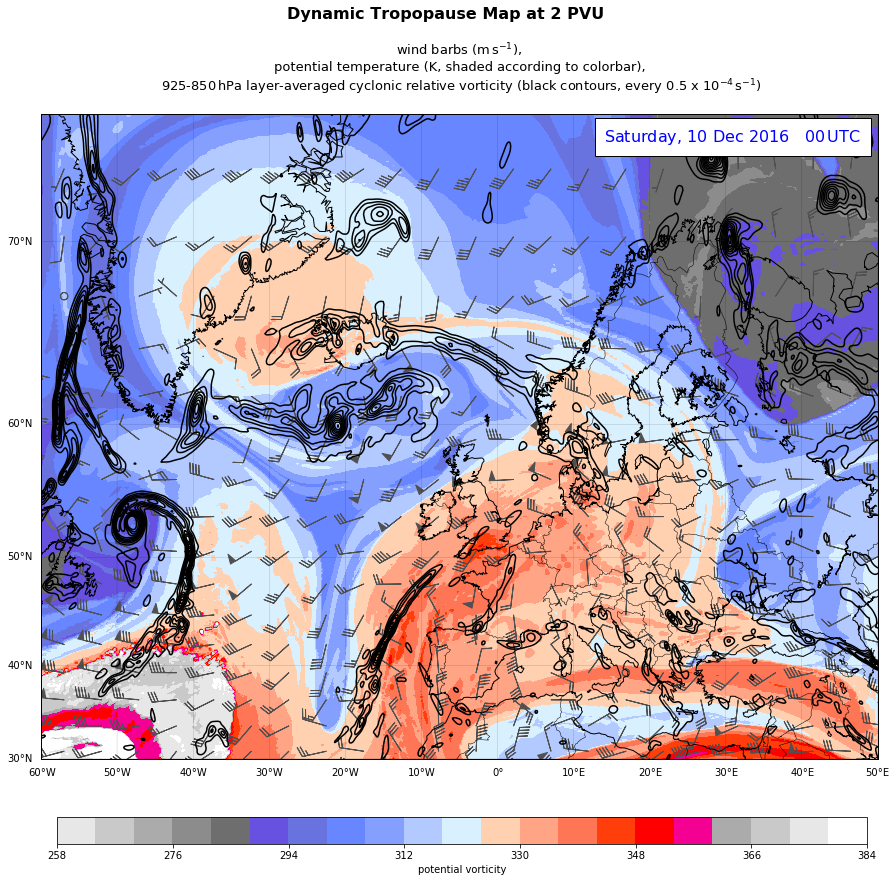

In [98]:
### PLOT FIGURE
fig = plt.figure(figsize=(15,12.5))
ax = fig.add_subplot(1,1,1)



### Draw Latitude Lines
m.drawparallels(np.arange(-90.,120.,10.),labels=[1,0,0,0],fontsize=10,linewidth=0.2)


### Draw Longitude Lines
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,0,1],fontsize=10,linewidth=0.2)


### Draw Map
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()


### Plot contour lines for pot. temp and fill
levels = np.arange(258,390,6)
cmap = colors.ListedColormap([no1, no2, no3, no4, no5, no6, no7, no8, no9, no10, \
                              no11, no12, no13, no14, no15, no16, no17, no18, no19, no20, \
                             no21])
norm = colors.BoundaryNorm(boundaries = levels, ncolors=cmap.N)
cs = m.contourf(plonsPT,platsPT,PT,levels,norm=norm,cmap=cmap)



### Plot contour lines for layer averaged rel. vort 925-850 hPa
thickness = np.arange(.5*10**(-4), 6*10**(-4),.5*10**(-4))
CVO = m.contour(plonsVO,platsVO,rel_vort,thickness,colors='k')

### plot wind barbs
plt.barbs(plonsUV,platsUV,u_wind2,v_wind2,barbcolor=[no22]) #darkslategray


### Add Colorbar
cbaxes = fig.add_axes([0.14, 0.05, 0.75, 0.03]) 
cbar = plt.colorbar(cs,orientation='horizontal',cax = cbaxes)#, cax = cbaxes)#, shrink=0.5)
cbar.ax.set_xlabel('potential vorticity')

### Add Textbox
ax.text(0.98,0.95, '%s, %s %s %s   %s$\,$UTC' %(calday, day, calmon, year, time),
       verticalalignment = 'bottom',  horizontalalignment='right',
       transform = ax.transAxes,
       color ='blue', fontsize=16,
       bbox={'facecolor':'white','alpha':1., 'pad':10})


### Title
fig.suptitle('Dynamic Tropopause Map at 2 PVU', fontsize=16, fontweight='bold') 
ax.set_title('wind barbs (m$\,$s$^{-1}$), \n \
potential temperature (K, shaded according to colorbar), \n \
925-850$\,$hPa layer-averaged cyclonic relative vorticity (black contours, every 0.5 x 10$^{-4}$$\,$s$^{-1}$) \n', \
            fontsize=13)



### Save
#plt.savefig('../synoptic_figs/DynTropo/%s%s%s_%s.png' % (year, mon, day,time))
## with header
plt.savefig('../synoptic_figs/DynTropo/%s%s%s_%s_header.png' % (year, mon, day,time))
#plt.savefig('dyn_tropo.png')     # Set the output file name

plt.show()